```
Copyright 2019, 2020. IBM All Rights Reserved.
```

```
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
```

# NYC Taxi Tip prediction (Ridge and Logistic Regression) using Snap ML
<div class="alert alert-block alert-info">
    <b>Snap ML</b> is packaged with <b>IBM® Watson™ Machine Learning Community Edition (WML CE)</b> in a conda package <b>pai4sk</b>.
</div>

### Taxi Tip prediction
In this example we will train a Ridge Regression model to predict the amount of tip paid. We also train a Logistic Regression model to predict if the user will pay less or greater than the median tip amount.<br/>
We will train the models using <b>scikit-learn</b>, <b>RAPIDS cuML</b> and <b>SnapML</b>, and compare the results.

### Data source
Dataset used for this notebook is downloaded from https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page with all rights reserved by Taxi & Limousine Commission(TLC), City of New York.

TLC Yellow Taxi Trip Records of June, 2019 is used in this notebook.

### Conda packages used for this notebook 
- `pai4sk       1.6.0   (Package for IBM Snap ML, provided in WML CE 1.7.0)`
- `cuml         0.11.0  (Package for RAPIDS cuML, provided in WML CE 1.7.0)`
- `scikit-learn 0.22.1  (Package for sklearn)`
- `dask         2.9.2   (Used here for distributed loading and feature engineering)`
- `dask-ml      1.1.1   (Used here for distributed pre-processing)`
- `seaborn      0.9.0   (Used for Visualization)`

### System Configuration 

|Configuration Parameter |	Value                         |
|:-----------------------|:-------------------------------|       
| **Machine** 	         | IBM Power9 AC922               |
| **CPU cores:**         | 40 (22 cores per socket)       |
| **Thread(s) per core:**| 4                              |
| **GPU** 	             | NVIDIA Tesla V100 SXM2 32GB    |


In [1]:
import dask.dataframe as dpd
import glob
import numpy as np
import time
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
import warnings
warnings.filterwarnings('ignore')

## A. Load one month yellow taxi data (Using dask dataframe for multi-core parallel processing)

In [2]:
#Download June 2019 TLC Yellow Taxi Trip records used in this notebook
!wget -nc https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-06.csv

File ‘yellow_tripdata_2019-06.csv’ already there; not retrieving.



In [3]:
ddf = dpd.read_csv('./yellow_tripdata_2019-06.csv',
                    parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])

In [4]:
ddf.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2019-06-01 00:55:13,2019-06-01 00:56:17,1,0.0,1,N,145,145,2,3.0,0.5,0.5,0.00,0.0,0.3,4.30,0.0
1,1,2019-06-01 00:06:31,2019-06-01 00:06:52,1,0.0,1,N,262,263,2,2.5,3.0,0.5,0.00,0.0,0.3,6.30,2.5
2,1,2019-06-01 00:17:05,2019-06-01 00:36:38,1,4.4,1,N,74,7,2,17.5,0.5,0.5,0.00,0.0,0.3,18.80,0.0
3,1,2019-06-01 00:59:02,2019-06-01 00:59:12,0,0.8,1,N,145,145,2,2.5,1.0,0.5,0.00,0.0,0.3,4.30,0.0
4,1,2019-06-01 00:03:25,2019-06-01 00:15:42,1,1.7,1,N,113,148,1,9.5,3.0,0.5,2.65,0.0,0.3,15.95,2.5


The yellow taxi trip records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts.

### Persist dask dataframe into memory (to avoid reloading from disk)

In [5]:
ddf = ddf.persist()

In [6]:
print('The dataset has',ddf.shape[0].compute(),'rows and',ddf.shape[1],'columns.')

The dataset has 6941024 rows and 18 columns.


## B. Cleaning the dataset

### 1. Drop trips with zero (or negative) tip_amount
As per the data dictionary of this dataset, tip_amount column does not include cash tips. So, we'll assume all the rows with 0 in tip_amount were tips paid in cash and drop all such rows!

In [7]:
filter_out_cash_tips = (ddf['tip_amount'] > 0)

In [8]:
filter_out_cash_tips.compute().value_counts()

True     4783107
False    2157917
Name: tip_amount, dtype: int64

In [9]:
#Retain only rows with tip amount greater than zero
ddf = ddf[filter_out_cash_tips]

### 2. Keep only trips with tip amount <= the fare amount

In [10]:
filter_out_big_tips = (ddf['tip_amount'] <= ddf['fare_amount'])

In [11]:
filter_out_big_tips.compute().value_counts()

True     4776619
False       6488
dtype: int64

In [12]:
ddf = ddf[filter_out_big_tips]

### 3. Remove trips with extreme fare amounts
Keep trips with fare >= the minimum amount 2 dollars and keep trips with fare amount less than 200 dollars

In [13]:
filter_out_extreme_fare = ((ddf['fare_amount'] >= 2) & (ddf['fare_amount'] < 200))

In [14]:
filter_out_extreme_fare.compute().value_counts()

True     4776058
False        561
Name: fare_amount, dtype: int64

In [15]:
ddf = ddf[filter_out_extreme_fare]

### 4. Drop total_amount charged to passengers (it also includes the tip_amount)

In [16]:
ddf = ddf.drop(['total_amount'], axis=1)

## C. Visualise the tip_amount distribution

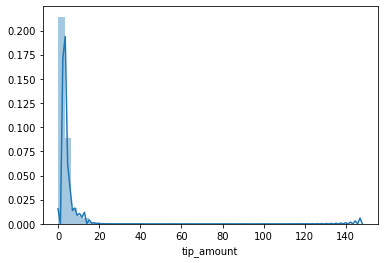

In [17]:
import seaborn as sns
sns.distplot(ddf['tip_amount'])

#### Print the dataset shape before preprocessing

In [18]:
print('The dataset has',ddf.shape[0].compute(),'rows and',ddf.shape[1],'columns.')

The dataset has 4776058 rows and 17 columns.


## D. Data Preprocessing

### Create derived features

In [19]:
#calculate trip time in minutes
trip_time = ddf['tpep_dropoff_datetime'] - ddf['tpep_pickup_datetime']
ddf['trip_time'] = trip_time.astype('timedelta64[m]')

In [20]:
#extract pickup and dropoff hour
ddf['pickup_hour'] = ddf['tpep_pickup_datetime'].dt.hour
ddf['dropoff_hour'] = ddf['tpep_dropoff_datetime'].dt.hour

In [21]:
#extract pickup and dropoff day of week
ddf['pickup_day'] = ddf['tpep_pickup_datetime'].dt.weekday_name
ddf['dropoff_day'] = ddf['tpep_dropoff_datetime'].dt.weekday_name

In [22]:
#Now that we have extracted required derived features from the pickup and dropoff datetime, drop them 
ddf = ddf.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1)

### One Hot encoding

In [23]:
get_dummy_col = ["VendorID","RatecodeID","store_and_fwd_flag","PULocationID", "DOLocationID","payment_type", "pickup_hour", "dropoff_hour", "pickup_day", "dropoff_day"]
ddf = ddf.categorize(columns=get_dummy_col)

In [24]:
ddf = dpd.get_dummies(ddf, columns = get_dummy_col)

### Use tip_amount as the target label for training

In [25]:
label = ddf[['tip_amount']].compute()
ddf = ddf.drop(['tip_amount'], axis=1)

### Transform features and then normalize values

In [26]:
from dask_ml.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(ddf)

In [27]:
# Convert Dask dataframe to Numpy array 
X = X.to_dask_array().compute()

In [28]:
from pai4sk.preprocessing import normalize

X = normalize(X, axis=1, norm='l1')

### Convert data to float32 data-type

In [29]:
X = X.astype('float32')
y = label.values.astype('float32')

In [30]:
print('X is of type :', X.__class__.__name__, 'and y is of type :', y.__class__.__name__)

X is of type : ndarray and y is of type : ndarray


## E. Split data into train and test sets
<div class="alert alert-block alert-warning">
It would have been preferable to use 80% of the data for training, but cuML fails with "out of memory" error if trained with that size of data. Switched to using 60% of data for training to not hit cuML OOM error.
<br/>
<b>Snap ML is capable of training with any amount of large data, even when using a single GPU!</b>
</div>

In [31]:
from pai4sk.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=17)

In [32]:
print('The train data has',X_train.shape[0],'rows and',X_train.shape[1],'columns.')
print('The test data has',X_test.shape[0],'rows and',X_test.shape[1],'columns.')

The train data has 2865634 rows and 606 columns.
The test data has 1910424 rows and 606 columns.


## F. Create Binary labels for Logistic Regression

In [33]:
y_median = np.median(y_train)
print(y_median)

2.46


In [34]:
# Binarize the labels based on if the tip amount is less or more than the median tip
y_train_bin = np.array(y_train)
for i in range(y_train.shape[0]):
    y_train_bin[i] = 1.0 if y_train[i] > y_median else 0.0
    
y_test_bin = np.array(y_test)
for i in range(y_test.shape[0]):
    y_test_bin[i] = 1.0 if y_test[i] > y_median else 0.0

## G. Use Optimized data formats for each framework

### Compute the sparsity of the dataset

In [35]:
from numpy import count_nonzero
sparsity = 1.0 - (count_nonzero(X_train) / float(X_train.shape[0]*X_train.shape[1]) )
print("The train dataset is %f percent sparse " % (sparsity*100))


The train dataset is 97.032121 percent sparse 


### Since this dataset is sparse, convert it to scipy sparse csr_matrix.<br/>Snap ML employs optimizations for the algorithms when applied to sparse data structures.

In [36]:
from scipy import sparse
X_train_csr = sparse.csr_matrix(X_train)
X_test_csr = sparse.csr_matrix(X_test)

### cuML does not have support for sparse dataset.<br/>Convert array to column-major (i.e. Fortran order) for faster training of cuML

In [37]:
X_train_col_major = np.asfortranarray(X_train)
X_test_col_major = np.asfortranarray(X_test)

### Regularizer value used across frameworks

In [38]:
reg = 1.0

## H. Train using scikit-learn
Sklearn has support for sparse datasets, but training sklearn on the sparse format of the datasets is very slow thus we use the numpy array format of the datasets

### &nbsp;&nbsp;Ridge Regression

#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Train

In [39]:
from sklearn.linear_model import Ridge
skl_ridge = Ridge(fit_intercept=False, alpha=reg)

t0 = time.time()
skl_ridge.fit(X_train, y_train)
skl_train_time_ridge = time.time()-t0
print("[sklearn-ridge] Training time (s): {0:.3f}".format(skl_train_time_ridge))

[sklearn-ridge] Training time (s): 12.022


#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Predict

In [40]:
t0 = time.time()
y_pred  = skl_ridge.predict(X_test)
skl_predict_time_ridge = time.time()-t0
print("[sklearn-ridge] Predict time (s): {0:.3f}\n".format(skl_predict_time_ridge))

[sklearn-ridge] Predict time (s): 1.298



#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Model evaluation

In [41]:
print("[sklearn-ridge] RMSE :", np.sqrt(mean_squared_error(y_test, y_pred)))
print("[sklearn-ridge] R2 score :", r2_score(y_test, y_pred))

[sklearn-ridge] RMSE : 1.2890767
[sklearn-ridge] R2 score : 0.7744372605295178


### &nbsp;&nbsp;Logistic Regression

#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Train

In [42]:
from sklearn.linear_model import LogisticRegression
skl_lor = LogisticRegression(fit_intercept=False, C=1.0/reg, dual=True, solver='liblinear')

t0 = time.time()
skl_lor.fit(X_train, y_train_bin)
skl_train_time_lor = time.time()-t0
print("[sklearn-logreg] Training time (s): {0:.3f}".format(skl_train_time_lor))

[sklearn-logreg] Training time (s): 34.482


#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Predict

In [43]:
t0 = time.time()
y_pred  = skl_lor.predict(X_test)
skl_predict_time_lor = time.time()-t0
print("[sklearn-logreg] Predict time (s): {0:.3f}".format(skl_predict_time_lor))

[sklearn-logreg] Predict time (s): 3.235


#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Model evaluation

In [44]:
print("[sklearn-logreg] Accuracy score :", accuracy_score(y_test_bin, y_pred))

[sklearn-logreg] Accuracy score : 0.7854910742327358


## I. Train using cuML

### &nbsp;&nbsp;Ridge Regression

#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Train

In [45]:
from cuml.linear_model import Ridge
cuml_ridge = Ridge(fit_intercept=False, alpha=reg)

t0 = time.time()
cuml_ridge.fit(X_train_col_major, y_train)
cuml_train_time_ridge = time.time()-t0
print("[cuML-ridge] Training time (s): {0:.3f}".format(cuml_train_time_ridge))

[cuML-ridge] Training time (s): 1.602


#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Predict

In [46]:
t0 = time.time()
y_pred  = cuml_ridge.predict(X_test_col_major)
cuml_predict_time_ridge = time.time()-t0
print("[cuML-ridge] Predict time (s): {0:.3f}\n".format(cuml_predict_time_ridge))

[cuML-ridge] Predict time (s): 0.513



#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Model evaluation

In [47]:
# Convert predicted cudf.dataframe.series.Series to numpy.ndarray
y_pred = y_pred.to_array()

print("[cuML-ridge] RMSE :", np.sqrt(mean_squared_error(y_test, y_pred)))
print("[cuML-ridge] R2 score :", r2_score(y_test, y_pred))

[cuML-ridge] RMSE : 1.2853705
[cuML-ridge] R2 score : 0.7757323738399636


### &nbsp;&nbsp;Logistic Regression

#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Train

In [48]:
from cuml.linear_model import LogisticRegression
cuml_lor = LogisticRegression(fit_intercept=False, C=X_train_col_major.shape[0]/reg, max_iter=100000, tol=1e-7)

t0 = time.time()
cuml_lor.fit(X_train_col_major, y_train_bin)
cuml_train_time_lor = time.time()-t0
print("[cuML-logreg] Training time (s): {0:.3f}".format(cuml_train_time_lor))

[cuML-logreg] Training time (s): 4.683


#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Predict

In [49]:
t0 = time.time()
y_pred  = cuml_lor.predict(X_test_col_major)
cuml_predict_time_lor = time.time()-t0
print("[cuML-logreg] Predict time (s): {0:.3f}".format(cuml_predict_time_lor))

[cuML-logreg] Predict time (s): 0.503


#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Model evaluation

In [50]:
# Convert predicted cudf.dataframe.series.Series to numpy.ndarray
y_pred = y_pred.to_array()

print("[cuML-logreg] Accuracy score :", accuracy_score(y_test_bin, y_pred))

[cuML-logreg] Accuracy score : 0.7846985800010887


## J. Train using Snap ML

### &nbsp;&nbsp;Ridge Regression

#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Train

In [51]:
from pai4sk import LinearRegression
sml_ridge = LinearRegression(penalty="l2", use_gpu=True, regularizer=reg, dual=True, fit_intercept=False)

t0 = time.time()
sml_ridge.fit(X_train_csr, y_train)
sml_train_time_ridge = time.time()-t0
print("[snapML-ridge] Training time (s): {0:.3f}".format(sml_train_time_ridge))

[Info] If set num_threads should be a multiple of 32. GPU training will run with num_threads=256.
[Warning] Parameter device_ids not set. The training will run on GPU 0.
[snapML-ridge] Training time (s): 1.336


#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Predict

In [52]:
t0 = time.time()
y_pred  = sml_ridge.predict(X_test_csr)
sml_predict_time_ridge = time.time()-t0
print("[snapML-ridge] Predict time (s): {0:.3f}\n".format(sml_predict_time_ridge))

[snapML-ridge] Predict time (s): 0.064



#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Model evaluation

In [53]:
print("[snapML-ridge] RMSE :", np.sqrt(mean_squared_error(y_test, y_pred)))
print("[snapML-ridge] R2 score :", r2_score(y_test, y_pred))

[snapML-ridge] RMSE : 1.2853008124674727
[snapML-ridge] R2 score : 0.7757567188356053


### &nbsp;&nbsp;Logistic Regression

#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Train

In [54]:
from pai4sk import LogisticRegression
sml_lor = LogisticRegression(use_gpu=True, regularizer=reg, dual=True, fit_intercept=False, penalty='l2')

t0 = time.time()
sml_lor.fit(X_train_csr, y_train_bin)
sml_train_time_lor = time.time()-t0
print("[snapML-logreg] Training time (s): {0:.3f}".format(sml_train_time_lor))

[Info] If set num_threads should be a multiple of 32. GPU training will run with num_threads=256.
[Warning] Parameter device_ids not set. The training will run on GPU 0.
[snapML-logreg] Training time (s): 0.746


#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Predict

In [55]:
t0 = time.time()
y_pred  = sml_lor.predict(X_test_csr)
sml_predict_time_lor = time.time()-t0
print("[snapML-logreg] Predict time (s): {0:.3f}".format(sml_predict_time_lor))

[snapML-logreg] Predict time (s): 0.066


#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Model evaluation

In [56]:
print("[snapML-logreg] Accuracy score :", accuracy_score(y_test_bin, y_pred))

[snapML-logreg] Accuracy score : 0.7856187945712575


## K. Speedup summary
<div class="alert alert-block alert-info">
The following results were obtained on an IBM Power AC922 server with NVIDIA Tesla V100 SXM2 32GB GPUs as mentioned in <a href='#System-Configuration'>System Configuration</a>.
<br/>Speedup times may vary based on the system architecture, load and software package versions used.
</div>

### &nbsp;&nbsp;&nbsp;Ridge Regression

In [57]:
# Training time
print("SnapML vs Sklearn training time speedup (Ridge) : %f " % (skl_train_time_ridge/sml_train_time_ridge))
print("CuML vs Sklearn training time speedup (Ridge) : %f \n" % (skl_train_time_ridge/cuml_train_time_ridge))

# Prediction time
print("SnapML vs Sklearn prediction time speedup (Ridge) : %f " % (skl_predict_time_ridge/sml_predict_time_ridge))
print("CuML vs Sklearn prediction time speedup (Ridge) : %f " % (skl_predict_time_ridge/cuml_predict_time_ridge))

SnapML vs Sklearn training time speedup (Ridge) : 8.999992 
CuML vs Sklearn training time speedup (Ridge) : 7.504729 

SnapML vs Sklearn prediction time speedup (Ridge) : 20.231386 
CuML vs Sklearn prediction time speedup (Ridge) : 2.532635 


### &nbsp;&nbsp;&nbsp;Logistic Regression

In [58]:
# Training time
print("SnapML vs Sklearn training time speedup (Logistic) : %f " % (skl_train_time_lor/sml_train_time_lor))
print("CuML vs Sklearn training time speedup (Logistic) : %f \n" % (skl_train_time_lor/cuml_train_time_lor))

# Prediction time
print("SnapML vs Sklearn prediction time speedup (Logistic) : %f " % (skl_predict_time_lor/sml_predict_time_lor))
print("CuML vs Sklearn prediction time speedup (Logistic) : %f " % (skl_predict_time_lor/cuml_predict_time_lor))

SnapML vs Sklearn training time speedup (Logistic) : 46.207038 
CuML vs Sklearn training time speedup (Logistic) : 7.362780 

SnapML vs Sklearn prediction time speedup (Logistic) : 48.846235 
CuML vs Sklearn prediction time speedup (Logistic) : 6.425519 


## Useful Resources for SnapML
<div class="alert alert-block alert-info">

1. <b>IBM WML-CE 1.6.2 Knowledge Center page for Snap ML</b> - https://www.ibm.com/support/knowledgecenter/en/SS5SF7_1.6.2/navigation/wmlce_getstarted_snapml.html
<br/>
2. <b>pai4sk(SnapML) API documentation</b> - https://ibmsoe.github.io/snap-ml-doc/
<br/>
3. <b>IBM Research page for Snap ML</b> - https://www.zurich.ibm.com/snapml/
</div>

<br/>

<br/>